## Configuration

### Imports

In [30]:
# Utilities
from IPython.display import display
import os
import numpy as np
import time
import pandas as pd

# MongoDB functionality
from pymongo import MongoClient, InsertOne, UpdateOne
from bson import ObjectId
from collections.abc import MutableMapping

# Graphics
import matplotlib.pyplot as plt
from matplotlib.pyplot import text
import seaborn as sns
sns.set(font_scale=0.9)
sns.set_style("whitegrid")
sns.set_style({'font.family':'monospace'})
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# Regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Network analysis
import networkx as nx

ROOT_DIR = "/home/mattia/javier/botbusters-spanish-general-elections-network-analysis/"

# Change path to root
os.chdir(ROOT_DIR)

# MongoDB parameters
mongoclient = MongoClient('localhost', 27017)
db = mongoclient.influence

In [31]:
sns.__version__
nx.__version__

'2.5'

### Support Functions

In [32]:
def flatten(d, parent_key='', sep='_'):
    """Formats MongoDB results
    
    Keyword arguments:
    d -- dictionary with key and uncleaned values
    parent_key --
    sep --
    """
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

def make_objid(text):
    """Makes an ObjectId of 4 bytes
    
    Keyword arguments:
    text -- string to be converted into Object ID
    """
    text = str(text)
    if not text.strip():
        return None
    try:
        return ObjectId(text.rjust(24,"0"))
    except Exception as ex:
        print(text, ex)
        return None

LIMIT=1000000
    
def get_tweets(collection):
    """
    Gets tweets
    
    collection - Tweets MongoDB collection
    """
    tweets = list(collection
                    .find({'sampled':True},{'_id': False, 'tweet_id': True, 'user_id' : True})
                   )
    
    print("Number of tweets:", len(tweets))
    tweets = [flatten(t) for t in tweets]
    df_tweets = pd.DataFrame(tweets)
    df_tweets.user_id = df_tweets.user_id.apply(lambda t : str(t))
    df_tweets.user_id = df_tweets.user_id.astype(str)
    df_tweets.rename(columns={'user_id':'tweet_author'},inplace=True)
    return df_tweets
    
    
def get_retweets(collection):
    """
    Gets retweets
    
    collection - Retweets MongoDB collection
    """
    retweets = list(collection
                    .find({'sampled':True},{'_id': False, 'tweet_id': True, 'user_id' : True})
                    .limit(LIMIT)
                   )
    
    print("Number of retweets:", len(retweets))
    retweets = [flatten(r) for r in retweets]
    df_retweets = pd.DataFrame(retweets)
    df_retweets.user_id = df_retweets.user_id.apply(lambda t : str(t))
    df_retweets.user_id = df_retweets.user_id.astype(str)
    df_retweets.rename(columns={'user_id':'retweet_author'},inplace=True)
    return df_retweets

def get_users(collection):
    """
    Gets users
    
    collection - Users MongoDB collection
    """
    users = list(collection.find({ '$and' : [ { 'sampled': True } , { 'botscore' : { '$gte' : 0 } }]},
                                 {'_id' : True, 'botscore' : True})
                 #.limit(LIMIT)
                )
    print("Number of sampled users with botscore in DB:", len(users))
    users = [flatten(u) for u in users]
    df_users = pd.DataFrame(users)
    df_users._id = df_users._id.apply(lambda t : str(t))
    df_users._id = df_users._id.astype(str)
    return df_users

## Data preparation

#### Getting tweets from DB...

In [4]:
df_tweets = get_tweets(db.tweets)
df_tweets.head(3)

Number of tweets: 358190


,tweet_author,tweet_id
0,000000000000000279465279,000001191464087064109058
1,000000000000001266667238,000001192787272975945729
2,000000000000000331220696,000001191467194519080960


In [5]:
df_tweets[df_tweets.duplicated()].count()
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358190 entries, 0 to 358189
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   tweet_author  358190 non-null  object
 1   tweet_id      358190 non-null  object
dtypes: object(2)
memory usage: 5.5+ MB


In [6]:
df_tweets.drop_duplicates(keep='first', inplace=True)

#### Getting retweets from DB...

In [7]:
df_retweets = get_retweets(db.retweets)
df_retweets.head(3)

Number of retweets: 1000000


,tweet_id,retweet_author
0,000001193667913368121351,000000000000004460826197
1,000001192581634291355649,000001075150211725619200
2,000001190659978471911424,000000000000000071190801


In [8]:
df_retweets[df_retweets.duplicated()].count()

tweet_id          417
retweet_author    417
dtype: int64

In [9]:
df_retweets.drop_duplicates(keep='first', inplace=True)
df_retweets.count()

tweet_id          999583
retweet_author    999583
dtype: int64

#### Getting users from DB...

In [10]:
users = get_users(db.users)
display(users.head(5))

Number of sampled users with botscore in DB: 458072


,_id,botscore
0,000000000000002266588688,0.16
1,000000000000000471028961,0.03
2,000000000000002792368467,0.11
3,000000000000004068857357,0.01
4,000000000000000006953012,0.03


#### Building directed-weighted retweet graph...

In [11]:
df_edges = df_retweets.set_index('tweet_id').join(df_tweets.set_index('tweet_id')).reset_index(drop=True)
df_edges.head(5)

,retweet_author,tweet_author
0,000000000000001125213258,000000000000000022488241
1,000000000000000250738602,000000000000000022488241
2,000000000000000194176051,000000000000000022488241
3,000000000000000376943216,000000000000000022488241
4,000001121249610612260865,000000000000000022488241


In [12]:
df_edges = df_edges.groupby(['retweet_author','tweet_author']).size().reset_index().rename(columns={0:'weight'})
df_edges.head(5)

,retweet_author,tweet_author,weight
0,000000000000000000003065,000000000000000016409683,1
1,000000000000000000003971,000000000000000142395787,1
2,000000000000000000012864,000000000000000055086343,1
3,000000000000000000012913,000000000000000198677200,1
4,000000000000000000013519,000000000000000050333404,1


In [13]:
implicated_users = []
implicated_users = list(set(list(df_edges.retweet_author.unique()) + list(df_edges.tweet_author.unique())))
#print("Implicated users:", len(implicated_users))

df_users = users[users._id.isin(implicated_users)]
print("Users with botscore:", len(df_users))

print("Retweets without botscore:", len(df_edges))
df_edges = df_edges[(df_edges.retweet_author.isin(df_users._id)) & (df_edges.tweet_author.isin(df_users._id))]
print("Retweets with botscore:", len(df_edges))

Users with botscore: 222555
Retweets without botscore: 924022
Retweets with botscore: 564212


In [14]:
G = nx.from_pandas_edgelist(df=df_edges, source='tweet_author', target='retweet_author', edge_attr='weight', create_using=nx.DiGraph)

In [15]:
node_attr = df_users.set_index('_id').to_dict('index')
nx.set_node_attributes(G, node_attr)

In [16]:
nx.write_graphml(G, "graphs/1.general-network.graphml")

## 1. Botscore distribution

0.17
0.34


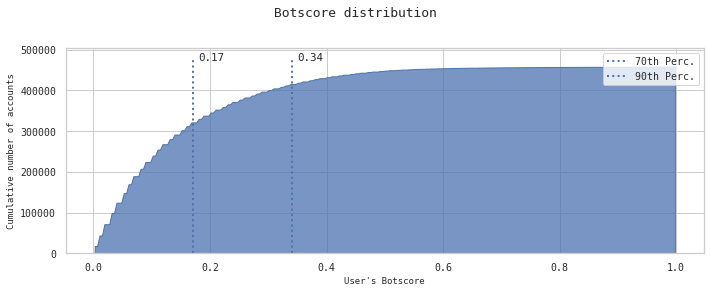

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(10,4))
palette = sns.diverging_palette(133, 10, as_cmap=True)

h = sns.histplot(users.botscore, 
                 #bins=40,
                 #hist=False, 
                 #kde=True,  
                 element="poly",
                 cumulative=True,
                 palette=palette,
                 cbar=True
                )

h.set_ylabel(fontsize="small", ylabel='Cumulative number of accounts')
h.set_xlabel(fontsize="small", xlabel='User\'s Botscore')

# vertical lines for percentiles
h_ylims = h.get_ylim()
prs = [70,90]
ps = np.percentile(a=users.botscore, q=prs, interpolation='lower')

for pr,p in zip(prs,ps):
    print(p)
    label = str(pr) + "th Perc."
    h.vlines(x=p, ymin=h_ylims[0], ymax=h_ylims[1], linewidth = 2, label=label, linestyles='dotted')
    text(x=p+0.01, y=h_ylims[1], s= str(p), verticalalignment='center')
    

    
# common legend
h.legend(loc="upper right")

fig.suptitle("Botscore distribution", y=1.01)
plt.tight_layout()

#plt.savefig("images/distribution.svg")
plt.show()

## 2. Graph properties

#### Three situations to compare. We sort users in ascending order of botscore:
##### 1. users < 70th percentile (legitimate network)
##### 2. users < 90th (shady network)
##### 3. all network (bot-interfered network)

In [31]:
%%time

df = pd.DataFrame()

prs = [70,90]
ps = np.percentile(a=users.botscore, q=prs, interpolation='lower')

percentile = {70: ps[0],
              90: ps[1],
              100: 1.01}

for percentage in [70, 90, 100]:
    print("Network " + str(percentage) +"%")
    print("--------------")
    
    nodes = (
        node
        for node, data
        in G.nodes(data=True)
        if data.get("botscore") < percentile[percentage] and data.get("botscore") >= 0
    )

    H = G.subgraph(nodes)
    
    print(nx.info(H))
    df_percentile = pd.DataFrame.from_dict({'out-degree':list(dict(H.out_degree()).values()),
                                      'in-degree':list(dict(H.in_degree()).values()),
                                      'out-strenght':list(dict(H.out_degree(weight='weight')).values()),
                                      'in-strenght':list(dict(H.in_degree(weight='weight')).values()),
                                      'eigenvector':list(dict(nx.eigenvector_centrality(H, weight='weight')).values()),
                                      'closeness':list(dict(nx.closeness_centrality(H)).values())
                                     },
                                      orient='columns')
    
    display(df_percentile.describe())
    
    df_percentile['network'] = str(percentage)+'%'
    
    if percentage == 70:
        df = df_percentile
    else:
        df = df.append(df_percentile, ignore_index=True)
    
    print()

Network 70%
--------------
Name: 
Type: DiGraph
Number of nodes: 133308
Number of edges: 281885
Average in degree:   2.1145
Average out degree:   2.1145


,out-degree,in-degree,out-strenght,in-strenght,eigenvector,closeness
count,133308.000000,133308.000000,133308.000000,133308.000000,1.333080e+05,133308.000000
mean,2.114539,2.114539,2.329815,2.329815,2.388727e-04,0.000351
std,37.516182,3.072212,46.647824,3.965869,2.728447e-03,0.000494
min,0.000000,0.000000,0.000000,0.000000,1.349189e-43,0.000000
25%,0.000000,1.000000,0.000000,1.000000,4.991998e-42,0.000008
50%,0.000000,1.000000,0.000000,1.000000,1.053311e-39,0.000015
75%,0.000000,2.000000,0.000000,2.000000,3.493174e-14,0.000861
max,3110.000000,87.000000,5053.000000,138.000000,2.813710e-01,0.002471



Network 90%
--------------
Name: 
Type: DiGraph
Number of nodes: 178200
Number of edges: 476334
Average in degree:   2.6730
Average out degree:   2.6730


,out-degree,in-degree,out-strenght,in-strenght,eigenvector,closeness
count,178200.000000,178200.000000,178200.000000,178200.000000,1.782000e+05,178200.000000
mean,2.673030,2.673030,2.941852,2.941852,1.836725e-04,0.000761
std,48.106122,4.214797,59.905045,5.371112,2.361772e-03,0.000957
min,0.000000,0.000000,0.000000,0.000000,1.331193e-49,0.000000
25%,0.000000,1.000000,0.000000,1.000000,5.324770e-48,0.000006
50%,0.000000,1.000000,0.000000,1.000000,1.463662e-37,0.000019
75%,0.000000,3.000000,0.000000,3.000000,1.190613e-08,0.001772
max,4591.000000,161.000000,7493.000000,229.000000,3.161184e-01,0.004003



Network 100%
--------------
Name: 
Type: DiGraph
Number of nodes: 197289
Number of edges: 564212
Average in degree:   2.8598
Average out degree:   2.8598


,out-degree,in-degree,out-strenght,in-strenght,eigenvector,closeness
count,197289.000000,197289.000000,197289.000000,197289.000000,1.972890e+05,197289.000000
mean,2.859825,2.859825,3.143145,3.143145,2.102814e-04,0.001072
std,51.156131,4.792913,63.625928,6.083669,2.241543e-03,0.001240
min,0.000000,0.000000,0.000000,0.000000,2.313000e-32,0.000000
25%,0.000000,1.000000,0.000000,1.000000,5.319899e-31,0.000005
50%,0.000000,1.000000,0.000000,1.000000,1.260241e-24,0.000020
75%,0.000000,3.000000,0.000000,3.000000,1.510381e-07,0.002339
max,5184.000000,209.000000,8414.000000,365.000000,2.017697e-01,0.004806



CPU times: user 32min 50s, sys: 3.43 s, total: 32min 53s
Wall time: 32min 53s


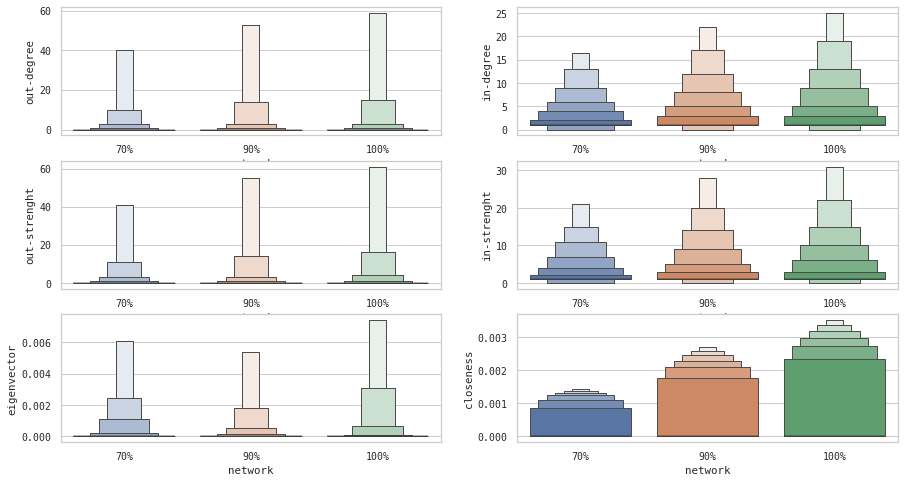

In [32]:
rows = 3
columns = 2

fig, axs = plt.subplots(rows, columns, figsize=(15,8))

row=0
column=0
for cat in ['out-degree','in-degree','out-strenght','in-strenght', 'eigenvector', 'closeness']:
    ax = axs[row][column]
    ax = sns.boxenplot(data=df,
                       x='network',
                       y=cat,
                       order=['70%','90%','100%'],
                       ax=ax,
                       showfliers=False,
                       dodge=False,
                       k_depth=6,
                       scale='linear'
                    )
    
    column=(column+1)%columns
    if column==0:
        row=row+1

### 3. Graph properties per botscore

In [17]:
%%time

nodes = (
    node
    for node, data
    in G.nodes(data=True)
    if data.get("botscore") <= 1 and data.get("botscore") >= 0
)

H = G.subgraph(nodes)

df_all = pd.DataFrame.from_dict({'out-degree':list(dict(H.out_degree()).values()),
                                  'in-degree':list(dict(H.in_degree()).values()),
                                  'out-strenght':list(dict(H.out_degree(weight='weight')).values()),
                                  'in-strenght':list(dict(H.in_degree(weight='weight')).values()),
                                  'eigenvector':list(dict(nx.eigenvector_centrality(H, weight='weight')).values()),
                                  'closeness':list(dict(nx.closeness_centrality(H)).values()),
                                  'botscore':list(dict(H.nodes(data='botscore')).values()),
                                 },
                                  orient='columns')
df_all.head()

CPU times: user 16min 37s, sys: 2.19 s, total: 16min 39s
Wall time: 16min 39s


,out-degree,in-degree,out-strenght,in-strenght,eigenvector,closeness,botscore
0,4,0,4,0,2.313000e-32,0.000000,0.18
1,0,1,0,1,5.319899e-31,0.000005,0.12
2,111,0,111,0,2.313000e-32,0.000000,0.01
3,0,1,0,1,5.319899e-31,0.000005,0.06
4,106,0,106,0,2.313000e-32,0.000000,0.32


In [18]:
BINS=20

rows = 3
columns = 2

## balance dataset for regression
df_balanced=df_all
df_balanced['botscore']=df_balanced['botscore'].round(decimals=1)
max_size = df_balanced['botscore'].value_counts().max()
lst = [df_balanced]

for botscore, botscore_group in df_balanced.groupby('botscore'):
    print(botscore, len(botscore_group))
    lst.append(botscore_group.sample(max_size-len(botscore_group), replace=True))
    
df_balanced = pd.concat(lst, ignore_index=True).reset_index(drop=True)

0.0 60006
0.1 63803
0.2 39113
0.3 16754
0.4 10910
0.5 4056
0.6 1673
0.7 518
0.8 367
0.9 83
1.0 6


CPU times: user 1h 49min 49s, sys: 7min 36s, total: 1h 57min 25s
Wall time: 6min 35s


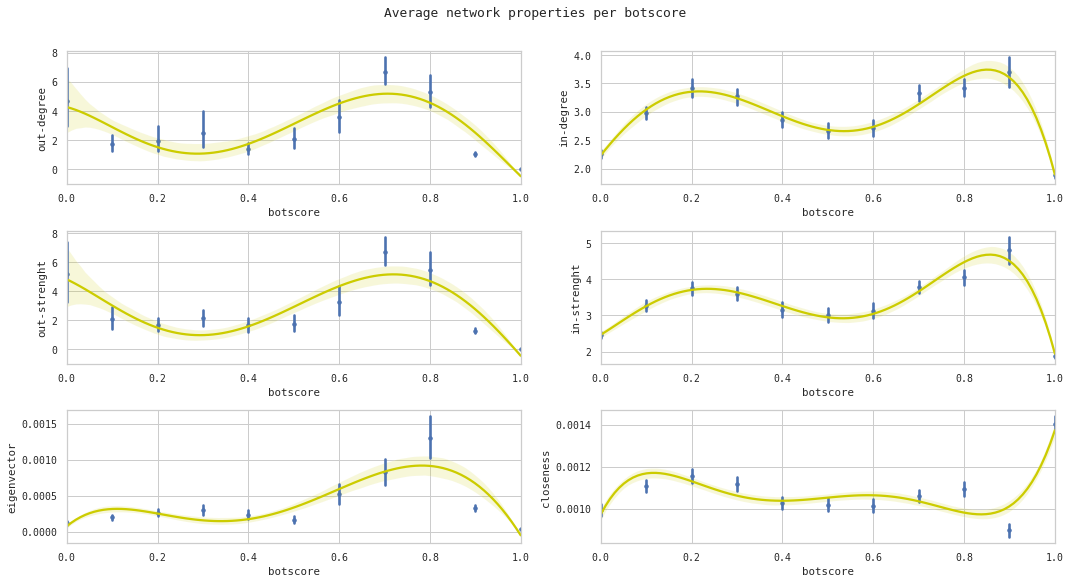

In [29]:
%%time
fig, axs = plt.subplots(rows, columns, figsize=(15,8))

row=0
column=0
for cat in ['out-degree','in-degree','out-strenght','in-strenght', 'eigenvector', 'closeness']:
    
    ax = axs[row][column]

    ## plot regression
    
    ax = sns.regplot(x='botscore',
            y=cat,
            x_bins=100,
            #data=df_all,
            data=df_balanced.sample(frac=.1),
            scatter_kws = {'color': 'b', 's':12},
            line_kws = {'color': '#CCCC00'},
            ax = ax,
            order=5
            )
    
    column=(column+1)%columns
    if column==0:
        row=row+1
    
    fig.suptitle("Average network properties per botscore", y=1.01)
    plt.tight_layout()

    #break